In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

jennwong_color = '#240FAB'

from glob import glob
datafiles = glob('data/*')

In [80]:
from sklearn.model_selection import train_test_split

In [4]:
stories_data = pd.read_csv(datafiles[0])
stories_data.head()

,Id,Perspective,Age,Lgbtq,Race,Phone,Topic,Title,Lede,Published at,...,Cringey,Haha,Me too,Interesting,Story texts,Link url,Link photo url,Link title,Link site name,Link body
0,2269,female,19.0,no,white,870,relationships,NaN,NaN,NaN,...,0,0,0,0,Well I was in my house and when I asked my eye...,NaN,NaN,NaN,NaN,NaN
1,2268,female,18.0,no,white,3253073887,bullying,NaN,I just need to work on my confidence,2020-01-06 00:00:00 UTC,...,1,1,1,1,My confident isnt the best. Its not with the w...,https://kidshealth.org/en/teens/self-esteem.html,NaN,How can I improve my self-esteem?,Teens Health,NaN
2,2267,female,18.0,yes,other,(304) 691-3740,puberty,NaN,NaN,NaN,...,0,0,0,0,His name is Jeffery but we call him jeff💖; I a...,NaN,NaN,NaN,NaN,NaN
3,2266,female,22.0,yes,white,0575809857,bullying,NaN,NaN,NaN,...,0,0,0,0,The was Robert My boyfriend ; Nothing really. ...,NaN,NaN,NaN,NaN,NaN
4,2265,female,15.0,yes,Latina,9793642515,puberty,NaN,NaN,NaN,...,0,0,0,0,They were my ex and I still loved him.💘But the...,NaN,NaN,NaN,NaN,NaN


### Data Cleaning
1. dropping columns that aren't helpful
2. drop duplicates
3. renaming columns to make them more useful

In [6]:
stories_data.columns = [column.lower().strip().replace(' ', '_') for column in stories_data.columns]
drop_columns = [column for column in stories_data.columns if 'link' in column]

# dropping the reactions since they aren't helpful
drop_columns.extend(['phone', 'title', 'lede', 'like', 'cringey', 'haha', 'me_too', 'interesting'])

stories_data.drop(drop_columns, axis=1, inplace=True, errors='ignore')

# renaming column

stories_data.rename(columns={
    'id':'story_id'
}, inplace=True)
print(stories_data.columns)

Index(['story_id', 'perspective', 'age', 'lgbtq', 'race', 'topic',
       'published_at', 'story_texts'],
      dtype='object')


In [63]:
reactions_data = pd.read_csv(datafiles[1])
story_reactions_count = reactions_data.groupby('Story').count()['Emoji'].to_frame().reset_index()
story_reactions_count.rename(columns=
    {'Story': 'story_id'
    , 'Emoji':'reaction_count'
    }, inplace=True)

In [70]:
# merging the two to get a complete dataset

data = pd.merge(stories_data, story_reactions_count
         , left_on=['story_id']
         , right_on=['story_id'], how='left')

In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2061 entries, 0 to 2060
Data columns (total 9 columns):
story_id          2061 non-null int64
perspective       2061 non-null object
age               1595 non-null float64
lgbtq             1595 non-null object
race              1595 non-null object
topic             2061 non-null object
published_at      819 non-null object
story_texts       2060 non-null object
reaction_count    681 non-null float64
dtypes: float64(2), int64(1), object(6)
memory usage: 161.0+ KB


In [85]:
data.age = data.age.astype(float)

# binarize it to make it easier to work with later on
data['published'] = data.published_at.isna()

# dropping duplicates in the story text
data.drop_duplicates(subset=['story_texts'], inplace=True)
data.dropna(subset=['story_texts'], inplace=True)
# need to reset index since we dropped duplicates
data.reset_index(inplace=True)
data.drop('index', axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2013 entries, 0 to 2012
Data columns (total 12 columns):
story_id          2013 non-null int64
perspective       2013 non-null object
age               1547 non-null float64
lgbtq             1547 non-null object
race              1547 non-null object
topic             2013 non-null object
published_at      819 non-null object
story_texts       2013 non-null object
reaction_count    681 non-null float64
published         2013 non-null bool
engaging          2013 non-null bool
story_length      2013 non-null object
dtypes: bool(2), float64(2), int64(1), object(7)
memory usage: 161.3+ KB


In [86]:
data.head()

,story_id,perspective,age,lgbtq,race,topic,published_at,story_texts,reaction_count,published,engaging,story_length
0,2269,female,19.0,no,white,relationships,NaN,Well I was in my house and when I asked my eye...,NaN,True,False,Well I was in my house and when I asked my eye...
1,2268,female,18.0,no,white,bullying,2020-01-06 00:00:00 UTC,My confident isnt the best. Its not with the w...,NaN,False,False,My confident isnt the best. Its not with the w...
2,2267,female,18.0,yes,other,puberty,NaN,His name is Jeffery but we call him jeff💖; I a...,NaN,True,False,His name is Jeffery but we call him jeff💖; I a...
3,2266,female,22.0,yes,white,bullying,NaN,The was Robert My boyfriend ; Nothing really. ...,NaN,True,False,The was Robert My boyfriend ; Nothing really. ...
4,2265,female,15.0,yes,Latina,puberty,NaN,They were my ex and I still loved him.💘But the...,NaN,True,False,They were my ex and I still loved him.💘But the...


In [122]:
data.age.dropna().astype(int).value_counts()

13                    215
14                    193
18                    151
15                    146
12                    124
19                    105
16                     94
11                     87
20                     79
17                     79
21                     49
10                     44
8                      26
23                     23
22                     21
9                      19
25                     16
27                      9
24                      6
28                      6
33                      6
12345678918             4
30                      3
9863                    3
60                      3
475313                  3
7                       3
6                       3
1                       3
29                      2
38                      2
45                      2
31                      2
79                      2
32                      2
8000                    1
26                      1
40                      1
42          

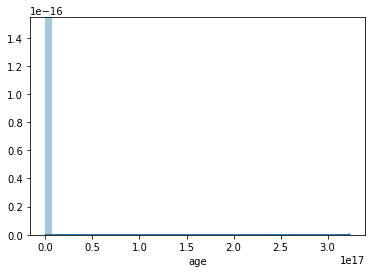

In [123]:
sns.distplot(data.age.dropna().astype(int))

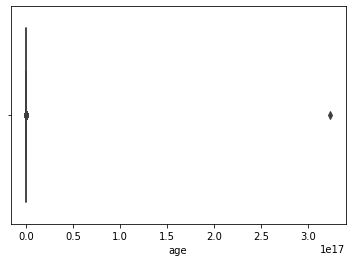

In [88]:
sns.boxplot(data=data, x='age')

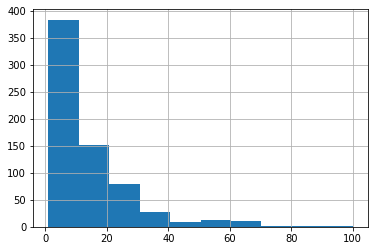

In [89]:
data.reaction_count.hist()

In [90]:
# what if we looked at it to see if there was a reaction or not

data['engaging'] = data.reaction_count > 0

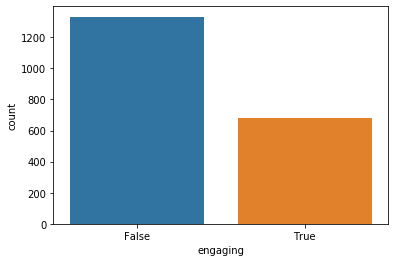

In [91]:
# note its not a balanced dataset we we need to either upsample or downsample

# probably going to downsample
sns.countplot(data.engaging);

In [92]:
data['story_length'] = data.story_texts.map(lambda x: len(x))

In [100]:
import string

In [110]:
data['cleaned_text'] = data.story_texts.map(lambda x: re.sub(r'[^\w\s]','', x))
data.cleaned_text


0       Well I was in my house and when I asked my eye...
1       My confident isnt the best Its not with the wa...
2       His name is Jeffery but we call him jeff I act...
3       The was Robert My boyfriend  Nothing really Ju...
4       They were my ex and I still loved himBut then ...
                              ...                        
2008    My parents say things that make me feel sad Im...
2009    My crush was dating my best friend He always i...
2010    My parents call me Larry but Ive been going by...
2011    Yo I had a wet dream last night And when I wok...
2012    Giiiiiirl these bumps are driving me loco Ive ...
Name: cleaned_text, Length: 2013, dtype: object

## Hypothesis:

We are interested to see if any of the provided columns are good predictors of engaging content

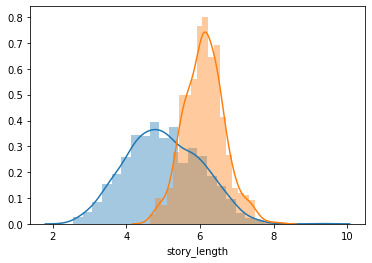

In [129]:
# data transformations
# by taking the log of the distributions, we are able to make it more normal as necessitated by logreg
sns.distplot(data[data.engaging == False]['story_length'].map(np.log))
sns.distplot(data[data.engaging == True]['story_length'].map(np.log))

plt.show();

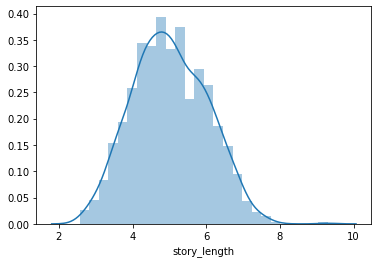

In [127]:
sns.distplot(data[data.engaging == False]['story_length'].map(np.log))

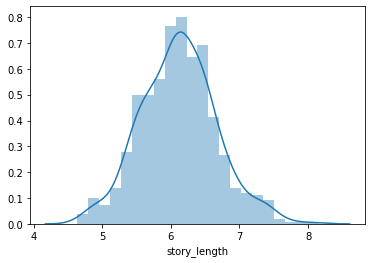

In [128]:
sns.distplot(data[data.engaging == True]['story_length'].map(np.log))

## statistical significance

we want to see if story length influences whether or not the story is engaging. because we are regressing a continuous independent variable to a discrete dependent variable, we will be using logistic regression

In [124]:
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
# need to look to see if they are statistically significant in differences

In [97]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [114]:
def uniqueness(story_text):
    tokenized = word_tokenize(story_text)
    length = len(tokenized)
    unique = len(set(tokenized))
    if length > 0: # since you can't divide by zero
        ratio = unique / length
    else: ratio = 0
    return ratio

In [116]:
data['uniqueness'] = data.cleaned_text.map(uniqueness)

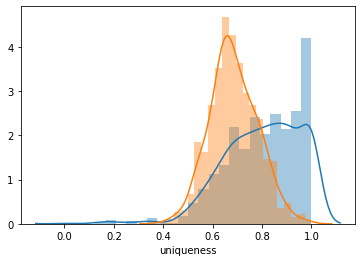

In [135]:
sns.distplot(data[data['engaging']==False]['uniqueness'])
sns.distplot(data[data['engaging']==True]['uniqueness'])

plt.show();

In [134]:
np.log(0)

/Users/jennwong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

In [ ]:
# need to look to see if they are statistically significant in differences